<a href="https://colab.research.google.com/github/vaishnavikamak04/customer-churn-nm/blob/main/customer_churn_nm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📦 1. Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [ ]:
# Optional: See all columns when displaying dataframes
pd.set_option('display.max_columns', None)

# 📥 2. Load the dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 🕵️ 3. First glance at the dataset
print(train_df.shape)
train_df.head()


(125000, 20)


,customer_id,age,location,subscription_type,payment_plan,num_subscription_pauses,payment_method,customer_service_inquiries,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked,churned
0,1,32,Montana,Free,Yearly,2,Paypal,Medium,-1606,22.391362,105.394516,0.176873,169,109,18,32,52,35,46,0
1,2,64,New Jersey,Free,Monthly,3,Paypal,Low,-2897,29.294210,52.501115,0.981811,55,163,44,33,12,25,37,1
2,3,51,Washington,Premium,Yearly,2,Credit Card,High,-348,15.400312,24.703696,0.048411,244,117,20,129,50,28,38,0
3,4,63,California,Family,Yearly,4,Apple Pay,Medium,-2894,22.842084,83.595480,0.035691,442,252,47,120,55,17,24,0
4,5,54,Washington,Family,Monthly,3,Paypal,High,-92,23.151163,52.578266,0.039738,243,230,41,66,40,32,47,0


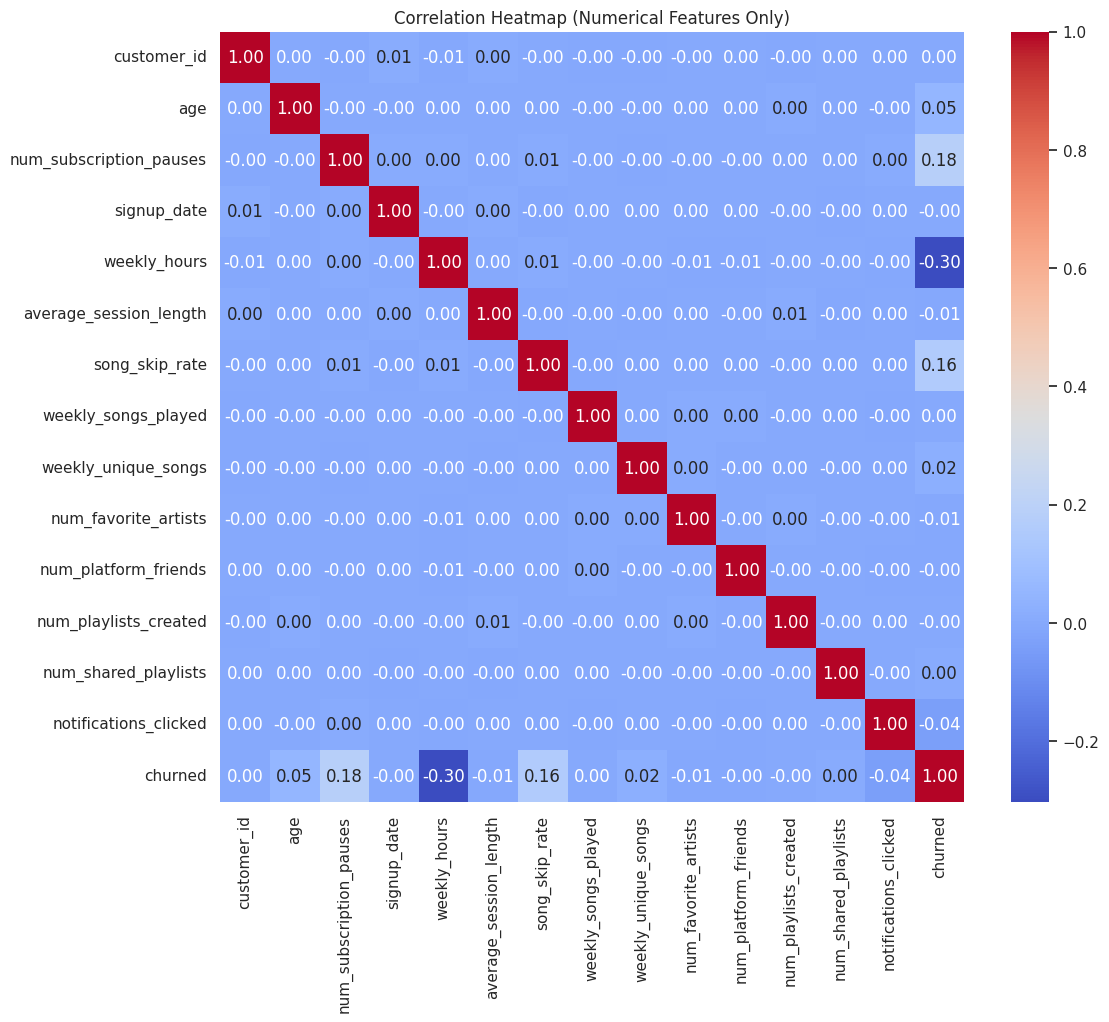

In [ ]:
# Select only numerical columns
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns

# Compute correlation matrix only on numerical data
corr_matrix = train_df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numerical Features Only)')
plt.show()



In [ ]:
# Check missing values count and percentage
missing_values = train_df.isnull().sum()
missing_percent = (missing_values / len(train_df)) * 100

missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing %': missing_percent})
print(missing_df[missing_df['Missing Count'] > 0])


Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []


In [ ]:
# Count duplicates
duplicates = train_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Optional: View duplicate rows
train_df[train_df.duplicated()]



Number of duplicate rows: 0


,customer_id,age,location,subscription_type,payment_plan,num_subscription_pauses,payment_method,customer_service_inquiries,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked,churned


In [ ]:
for df in [train_df, test_df]:
    df['account_months'] = (-df['signup_date']) / 30
    df['account_months'] = df['account_months'].round(1)

# Optional: Print to check shape and column list
print("Train Columns:", train_df.columns.tolist())
print("Test Columns:", test_df.columns.tolist())

Train Columns: ['customer_id', 'age', 'location', 'subscription_type', 'payment_plan', 'num_subscription_pauses', 'payment_method', 'customer_service_inquiries', 'signup_date', 'weekly_hours', 'average_session_length', 'song_skip_rate', 'weekly_songs_played', 'weekly_unique_songs', 'num_favorite_artists', 'num_platform_friends', 'num_playlists_created', 'num_shared_playlists', 'notifications_clicked', 'churned', 'account_months']
Test Columns: ['customer_id', 'age', 'location', 'subscription_type', 'payment_plan', 'num_subscription_pauses', 'payment_method', 'customer_service_inquiries', 'signup_date', 'weekly_hours', 'average_session_length', 'song_skip_rate', 'weekly_songs_played', 'weekly_unique_songs', 'num_favorite_artists', 'num_platform_friends', 'num_playlists_created', 'num_shared_playlists', 'notifications_clicked', 'account_months']


In [ ]:
def calculate_engagement_score(df):
    return (
        df['weekly_hours'] * 2 +
        df['average_session_length'] * 1.5 +
        df['notifications_clicked'] * 1.2 +
        df['num_favorite_artists'] * 1 -
        df['num_subscription_pauses'] * 3
    )

# Apply to both train and test
train_df['engagement_score'] = calculate_engagement_score(train_df)
test_df['engagement_score'] = calculate_engagement_score(test_df)


In [ ]:
# cols_to_drop = [
#     'customer_id',
#     'signup_date',
#     'location',
#     'payment_method',
#     'num_favorite_artists',
#     'weekly_songs_played',
#     'num_platform_friends',
#     'num_playlists_created',
#     'num_shared_playlists'
# ]

# train_df.drop(columns=cols_to_drop, inplace=True)
# test_df.drop(columns=cols_to_drop, inplace=True)


In [ ]:
# Export preprocessed training dataset
train_df.to_csv('preprocessed_train.csv', index=False)

# Export preprocessed test dataset
test_df.to_csv('preprocessed_test.csv', index=False)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the preprocessed dataset
df = pd.read_csv("preprocessed_train.csv")

# Drop any non-feature columns (if not already dropped)
columns_to_drop = [
    'customer_id',
    'signup_date',
    'location'
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Encode categorical features using one-hot encoding
df = pd.get_dummies(df, drop_first=True)

# Define target and features
X = df.drop(columns=["churned"])
y = df["churned"]

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost
xgb_preds = xgb_model.predict(X_val)
print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_val, xgb_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, xgb_preds))
print("Classification Report:\n", classification_report(y_val, xgb_preds))

# Evaluate Random Forest
rf_preds = rf_model.predict(X_val)
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_val, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, rf_preds))
print("Classification Report:\n", classification_report(y_val, rf_preds))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:22:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
Accuracy: 0.8488
Confusion Matrix:
 [[10314  1851]
 [ 1929 10906]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85     12165
           1       0.85      0.85      0.85     12835

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Random Forest Results:
Accuracy: 0.84656
Confusion Matrix:
 [[10159  2006]
 [ 1830 11005]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84     12165
           1       0.85      0.86      0.85     12835

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.5 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool
import pandas as pd

# Load preprocessed data
train_df = pd.read_csv("preprocessed_train.csv")

# Drop unnecessary columns
columns_to_drop = [
    'customer_id',
    'location',
    'signup_date',
]
train_df = train_df.drop(columns=columns_to_drop)

# Define features and target
X = train_df.drop("churned", axis=1)
y = train_df["churned"]

# Identify categorical columns
categorical_features = ['subscription_type', 'payment_plan', 'payment_method', 'customer_service_inquiries']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
val_pool = Pool(X_val, y_val, cat_features=categorical_features)

# Initialize and train CatBoost model
cat_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    verbose=100,
    random_seed=42
)
cat_model.fit(train_pool)

# Predict on validation data
val_preds = cat_model.predict(val_pool)

# Evaluate performance
print("CatBoost Evaluation Results:")
print("Accuracy:", accuracy_score(y_val, val_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, val_preds))
print("Classification Report:\n", classification_report(y_val, val_preds))


0:	learn: 0.6183401	total: 96.2ms	remaining: 48s
100:	learn: 0.2935780	total: 9.84s	remaining: 38.9s
200:	learn: 0.2855085	total: 20s	remaining: 29.8s
300:	learn: 0.2784937	total: 30.3s	remaining: 20.1s
400:	learn: 0.2720427	total: 39.7s	remaining: 9.79s
499:	learn: 0.2658380	total: 50s	remaining: 0us
CatBoost Evaluation Results:
Accuracy: 0.84844
Confusion Matrix:
 [[10390  1775]
 [ 2014 10821]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85     12165
           1       0.86      0.84      0.85     12835

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

